In [1]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.optimizers import Adam
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.wrappers.scikit_learn import KerasClassifier
from collections import defaultdict

Using TensorFlow backend.


### Sequence Classification Problem
#### convert text into word vectors
#### train LSTM
#### have a dense layer (activation is softmax) at the end
#### the output from the dense layer is a number, and we can think of it as a probability

In [2]:
# Data preparation and add a column for label:
path = "../"
admission = pd.read_csv(path + 'ADMISSIONS.csv', usecols=['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME', 
                                                   'DEATHTIME', 'ADMISSION_TYPE', 'DISCHARGE_LOCATION', 'DIAGNOSIS'])
# convert admission time and discharge time death time to correct format
admission.ADMITTIME = pd.to_datetime(admission.ADMITTIME, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')
admission.DISCHTIME = pd.to_datetime(admission.DISCHTIME, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')
admission.DEATHTIME = pd.to_datetime(admission.DEATHTIME, format = '%Y-%m-%d %H:%M:%S', errors = 'coerce')
# sort before group by
admission = admission.sort_values(['SUBJECT_ID','ADMITTIME'])
admission = admission.reset_index(drop = True)

# add the next admission date and type for each subject 
admission['NEXT_ADMITTIME'] = admission.groupby('SUBJECT_ID').ADMITTIME.shift(-1)
admission['NEXT_ADMISSION_TYPE'] = admission.groupby('SUBJECT_ID').ADMISSION_TYPE.shift(-1)
admission = admission.sort_values(['SUBJECT_ID','ADMITTIME'])
# back fill
admission[['NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']] = admission.groupby(['SUBJECT_ID'])[['NEXT_ADMITTIME','NEXT_ADMISSION_TYPE']].fillna(method = 'bfill')
# compute days elapsed until next readmission
admission['DAYS_NEXT_ADMIT']=  (admission.NEXT_ADMITTIME - admission.DISCHTIME).dt.total_seconds()/(24*60*60)
# number of records that were readmitted in less than or equal to 30 days: 3390
records = admission[admission.DAYS_NEXT_ADMIT <= 30]
# read the notes table 
notes = pd.read_csv(path + "NOTEEVENTS.csv")
discharge_sum = notes.loc[notes.CATEGORY == 'Discharge summary']
notes_dis_sum_last = (discharge_sum.groupby(['SUBJECT_ID','HADM_ID']).nth(-1)).reset_index()
# perform a left join of the two datatable
dt_table = pd.merge(admission,notes_dis_sum_last[['SUBJECT_ID','HADM_ID','TEXT']], on = ['SUBJECT_ID','HADM_ID'],how = 'left')
# filter out new born records because a lot of them don't have discharge summary
dt_table = dt_table[dt_table.ADMISSION_TYPE != 'NEWBORN']
# add a column for label
dt_table['LABEL'] = (dt_table.DAYS_NEXT_ADMIT <= 30).astype('int')
# split the dataset into 80% training, 10% validation, and 10% testing:
# shuffle the dataset first:
dt_table_shuffled = dt_table.sample(n=len(dt_table), random_state=42)
dt_table_shuffled = dt_table_shuffled.reset_index(drop=True)
dt_train = dt_table_shuffled.sample(frac=0.80, random_state=42)
dt_val_test = dt_table_shuffled.drop(dt_train.index)
dt_val = dt_val_test.sample(frac=0.50, random_state=42)
dt_test = dt_val_test.drop(dt_val.index)
# skip sub-sampling


C:\Users\Rohit\AppData\Local\conda\conda\envs\py36\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
dt_table_shuffled[:2]

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,DISCHARGE_LOCATION,DIAGNOSIS,NEXT_ADMITTIME,NEXT_ADMISSION_TYPE,DAYS_NEXT_ADMIT,TEXT,LABEL
0,25985,21284,126923,2168-05-03 07:15:00,2168-05-10 14:50:00,NaT,ELECTIVE,HOME HEALTH CARE,ASCENDING AORTIC ANEURSYM\ ASCENDING AROTA W/...,2171-02-04 04:04:00,EMERGENCY,999.551389,Admission Date: [**2168-5-3**] Discharg...,0
1,11435,9344,116730,2199-05-21 02:59:00,2199-06-26 14:32:00,NaT,EMERGENCY,REHAB/DISTINCT PART HOSP,GUN SHOT WOUND,NaT,NaN,NaN,Admission Date: [**2199-5-21**] ...,0


In [4]:
from nltk.stem.porter import *

import string
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
import numpy as np
punctuation = set(string.punctuation)

def preprocess(text):
    result = []
    notes = text.strip().split()
    for words in notes:
        r = ''.join([c for c in words.lower() if not c in punctuation])
        if (r not in gensim.parsing.preprocessing.STOPWORDS):
            result.append(r)
    return result

C:\Users\Rohit\AppData\Local\conda\conda\envs\py36\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [5]:
m = (dt_table_shuffled[:1].TEXT.values.astype(str))[0]

#print (m)
idx1 = m.find('ADMISSION DIAGNOSIS')
idx2 = m.find('DISCHARGE DIAGNOSIS')
idx3 = m.find('[**Doctor Last Name **]')
print (idx1, idx2, idx3)
print (m[idx1:idx3].strip())
l = m[idx1:idx3].strip()
l = preprocess(l)
print (l)#
print (len(l))

134 409 4796
ADMISSION DIAGNOSIS:
1. Aneurysm of ascending aorta and aortic arch.
2. Hypertension.
3. Hypercholesterolemia.
4. Diabetes mellitus, type 2.
5. Hypothyroidism.
6. Glaucoma.
7. Osteoarthritis.
8. Status post total abdominal hysterectomy.
9. Status post colonic polypectomy.


DISCHARGE DIAGNOSIS:
1. Aneurysm of ascending aorta and aortic arch, status post
   replacement of ascending aorta and hemi-arch and aortic
   valve resuspension with 32 mm gel-weave tube graft.
2. Hypertension.
3. Hypercholesterolemia.
4. Diabetes mellitus, type 2.
5. Hypothyroidism.
6. Glaucoma.
7. Osteoarthritis.
8. Status post total abdominal hysterectomy.
9. Status post colonic polypectomy.


HISTORY OF PRESENT ILLNESS:  The patient is a 71-year-old
female who was found to have mildly dilated abdominal aortic
aneurysm on work-up for a heart murmur she had been diagnosed
with. This had been followed serially with echocardiogram and
was found to have grown to 5.5 cm in [**2168-2-23**]. As noted,
she 

In [8]:
#only take the last 500 words, instead take the middle useful and preprocess that
def get_sentence(data):
    X = []
    for notes in data:
        idx1 = m.find('ADMISSION DIAGNOSIS')
        #idx2 = m.find('DISCHARGE DIAGNOSIS')
        idx3 = m.find('[**Doctor Last Name **]')
        #print (idx1, idx2, idx3)
        #print (m[idx1:idx3].strip())
        l = m[idx1:idx3].strip()
        l = preprocess(l)
        #print (l)
        #break
        X.append(l)
    return X
X_all = get_sentence(dt_table_shuffled.TEXT.values.astype(str))

In [9]:
X_all = np.array(X_all)

len(X_all)

In [11]:
embeddingIdx = {}
with open("../biomedicalWordVectors/word2vecTools/types.txt",encoding="utf8") as types, open("../biomedicalWordVectors/word2vecTools/vectors.txt",encoding="utf8") as vectors:    
    for word, vector in zip(types, vectors):
        word = word.strip()
        values = vector.strip().split()
        coeffs = np.asarray(values, dtype='float32')
        embeddingIdx[word] = coeffs

In [16]:
label = dt_table_shuffled.LABEL.values

In [17]:
EMBEDDING_DIM = 200
#embeddingMatrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
embeddingMatrix = np.zeros((len(dt_table_shuffled), EMBEDDING_DIM))

unknownWord = defaultdict(int)
knownwordCount = 0
index2word = defaultdict(str)

for idx in range(len(X_all)):
    text = X_all[idx]
    #vec = np.zeros(EMBEDDING_DIM, dtype=float)
    for word in text:
        vec = np.zeros(EMBEDDING_DIM, dtype=float)
        # Get the embedding for word w
        if word not in embeddingIdx: # This word has no entry in the embeddings dict of word2vec representation we created
            unknownWord[word] += 1
            continue 
        
        vec = embeddingIdx[word]
        embeddingMatrix[idx] += vec
        knownwordCount += 1
    # Average the feature vector by the length of the title
    if len(text) != 0: embeddingMatrix[idx] = embeddingMatrix[idx]/float(len(text))

print(len(unknownWord))
print(knownwordCount)

11
22540833


In [18]:
len(embeddingMatrix[0])

200

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_val = train_test_split(embeddingMatrix, train_size=0.75, random_state=0)
Y_train, Y_val = train_test_split(label, train_size=0.75, random_state=0)

C:\Users\Rohit\AppData\Local\conda\conda\envs\py36\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [20]:
# Create weight dictionary for the +ve and -ve classes
weightDict = { 1:8.07217308907, 0:0.53301562141}

In [21]:
MAX_SEQUENCE_LENGTH = 200
from keras.layers import Embedding
embedding_layer = Embedding(len(embeddingMatrix),
                            EMBEDDING_DIM,
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [28]:
# Bulid LSTM model:
hidden_size = 32
max_epochs = 10
batch_size = 128
model = Sequential()
model.add(embedding_layer)
# return the last output from LSTM --> use this as a representation for the entire sequence
# the paper : Predicting hospital readmission for lupus patients: An RNN-LSTM-based T deep-learning methodology
# used hidden_size = 32, minibatch = 512, Adam, sigmoid for output activation, and binary cross-entropy
model.add(LSTM(hidden_size, activation='sigmoid'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=Adam(lr=0.0001))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 200)          10222600  
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                29824     
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 10,252,457
Trainable params: 29,857
Non-trainable params: 10,222,600
_________________________________________________________________


In [29]:
print(X_train.shape)

(38334, 200)


In [30]:
# Training the network:
model.fit(X_train, Y_train, epochs=max_epochs, batch_size=batch_size, class_weight=weightDict)

Epoch 1/70
38334/38334 [==============================] - 45s 1ms/step - loss: 0.7188 - acc: 0.4077
Epoch 2/70
38334/38334 [==============================] - 46s 1ms/step - loss: 0.7091 - acc: 0.5052
Epoch 3/70
38334/38334 [==============================] - 47s 1ms/step - loss: 0.7080 - acc: 0.4965
Epoch 4/70
38334/38334 [==============================] - 48s 1ms/step - loss: 0.7055 - acc: 0.5181
Epoch 5/70
38334/38334 [==============================] - 47s 1ms/step - loss: 0.7065 - acc: 0.4995
Epoch 6/70
38334/38334 [==============================] - 47s 1ms/step - loss: 0.7046 - acc: 0.5094
Epoch 7/70
38334/38334 [==============================] - 51s 1ms/step - loss: 0.7048 - acc: 0.4993
Epoch 8/70
38334/38334 [==============================] - 49s 1ms/step - loss: 0.7026 - acc: 0.5202
Epoch 9/70
38334/38334 [==============================] - 51s 1ms/step - loss: 0.7022 - acc: 0.4908
Epoch 10/70
38334/38334 [==============================] - 55s 1ms/step - loss: 0.7017 - acc: 0.5013

In [31]:
# Save trained model to JSON:
modelJson = model.to_json()
with open("trainedModel_70_epochs.json", "w") as f:
    f.write(modelJson)
model.save_weights("trainedWeights_70_epochs.h5s")
print("Saved model description and weights")

Saved model description and weights


In [32]:
y_valPred = model.predict_classes(X_val)
y_valPred = np.reshape(y_valPred, (-1))
print(y_valPred.shape)
print(y_valPred[0])


(12779,)
0


AUC for training:  0.5
AUC for validation:  0.5
0
821
Macro F1 score: 0.000000, Micro F1 score: 0.935754


C:\Users\Rohit\AppData\Local\conda\conda\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


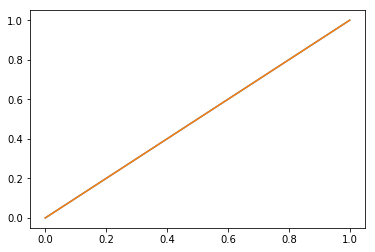

In [33]:
# Evaluation based on AUC and F1 scores and Plot ROC
from sklearn.metrics import roc_curve, auc, f1_score
y_trainPred = model.predict_classes(X_train)
y_trainPred = np.reshape(y_trainPred, (-1))
fpr_train, tpr_train, threshold_train = roc_curve(Y_train, y_trainPred)
fpr_val, tpr_val, threshold_val = roc_curve(Y_val, y_valPred)


roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_val = auc(fpr_val, tpr_val)


plt.plot(fpr_train, tpr_train, label='ROC Curve for training: (%0.2f)' % (roc_auc_train))
plt.plot(fpr_val, tpr_val, label='ROC Curve for training: (%0.2f)' % (roc_auc_val))
#plt.plot(fpr_test, tpr_test, label='ROC Curve for training: (%0.2f)' % (roc_auc_test))

print("AUC for training: ", roc_auc_train)
print("AUC for validation: ", roc_auc_val)
ones_count = 0
for i in y_valPred:
    if i == 1:
        ones_count = ones_count + 1
print(ones_count)
ones_true_count = 0
for i in Y_val:
    if i == 1:
        ones_true_count = ones_true_count + 1
print(ones_true_count)
macroF1 = f1_score(Y_val, y_valPred)
microF1 = f1_score(Y_val, y_valPred, average='micro')

print("Macro F1 score: %02f, Micro F1 score: %02f" % (macroF1, microF1))

In [90]:
len(y_trainPred)

38334

In [94]:
model.predict_proba(X_train)

array([[0.11280287],
       [0.11280287],
       [0.11280287],
       ...,
       [0.11280287],
       [0.11280287],
       [0.11280287]], dtype=float32)

In [99]:
np.bincount(label)

array([47947,  3166], dtype=int64)

In [18]:
print(X_all.shape)
#print(data.shape)
#print(text.shape)
#print(x_train.shape)
#print(y_train.shape)
#print(label.shape)

(51113, 368)


NameError: name 'label' is not defined

In [113]:
# Tokenize words:
#text = dt_table_shuffled.TEXT.values.astype(str)
label = dt_table_shuffled.LABEL.values
tokenizer = Tokenizer()
#tokenizer.fit_on_texts(text)
tokenizer.fit_on_texts(X_all)
#sequences = tokenizer.texts_to_sequences(text)
sequences = tokenizer.texts_to_sequences(X_all)

In [114]:
MAX_SEQUENCE_LENGTH = 500
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
word_index = tokenizer.word_index

In [5]:
print(dt_table_shuffled.shape)
print(dt_table_shuffled.shape[0])

(51113, 14)
51113


In [6]:
# split tokenized data into 80% training, 10% validation, and 10% testing
indices = np.arange(len(dt_table_shuffled))
#np.random.shuffle(indices)
#data = 
n_rows = int(dt_table_shuffled.shape[0])
# testing code and model on a quarter of the data
data = data[:int(0.25 * n_rows), :]
label = label[:int(0.25 * n_rows)]
x_train = data[:int(0.8 * n_rows), :]
x_val = data[int(0.8 * n_rows):int(0.9 * n_rows), :]
x_test = data[int(0.9 * n_rows):, :]
y_train = label[:int(0.8 * n_rows)]
y_val = label[int(0.8 * n_rows):int(0.9 * n_rows)]
y_test = label[int(0.9 * n_rows):]

In [25]:
from nltk.stem.porter import *

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
stemmer = PorterStemmer()
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        #if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
        result.append(lemmatize_stemming(token))
    return result

In [40]:
m = preprocess(dt_table_shuffled.TEXT.values[0])
#print(m)

In [63]:
# prepare the embedding
embeddingIdx = {}
with open("../embeddings/word2vecTools/types.txt") as types, open("../embeddings/word2vecTools/vectors.txt") as vectors:
    for word, vector in zip(types, vectors):
        values = vector.split()
        coeffs = np.asarray(values, dtype='float32')
        embeddingIdx[word] = coeffs
print("Size of the BioASQ vocabulary: ", len(embeddingIdx))

Size of the BioASQ vocabulary:  1701632


In [82]:
EMBEDDING_DIM = 300
embeddingMatrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
unknownWord = defaultdict(int)
knownwordCount = 0
index2word = defaultdict(str)
for word, i in word_index.items():
    embeddingVector = embeddingIdx.get(word)
    index2word[i] = word
    if embeddingVector is not None:
        embeddingMatrix[i] = embeddingVector
        knownwordCount = knownwordCount + 1
    else:
        unknownWord[word] = unknownWord[word] + 1
        #embeddingMatrix[i] = np.random.uniform(-0.25, 0.25, 300)
        
print(len(unknownWord))
print(knownwordCount)

113994
0


In [89]:
print(index2word[100000])

21120


In [93]:
EMBEDDING_DIM = 300
#embeddingSentenceMatrix = np.zeros((X_all.shape[0] + 1, EMBEDDING_DIM))
embeddingSentenceMatrix = []
unknownWord = defaultdict(int)
knownwordCount = 0
for sentence in data:
    sentenceVec = np.zeros(300)
    for i in range(len(sentence)):
        #word = index2word[i]
        sentenceVec = sentenceVec + embeddingMatrix[i]
    sentenceVec = sentenceVec / 500
    embeddingSentenceMatrix.append(sentenceVec)

In [99]:
print(len(word_index))
print(embeddingSentenceMatrix.shape)
embeddingSentenceMatrix = np.array(embeddingSentenceMatrix)


113994
(51113, 300)


In [104]:
from keras.layers import Embedding
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embeddingMatrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

In [121]:
# Bulid LSTM model:
hidden_size = 32
max_epochs = 10
batch_size = 128
model = Sequential()
model.add(embedding_layer)
# return the last output from LSTM --> use this as a representation for the entire sequence
# the paper : Predicting hospital readmission for lupus patients: An RNN-LSTM-based T deep-learning methodology
# used hidden_size = 32, minibatch = 512, Adam, sigmoid for output activation, and binary cross-entropy
model.add(LSTM(hidden_size, activation='sigmoid'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='softmax'))

model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=Adam(lr=0.0001))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 500, 300)          34198500  
_________________________________________________________________
lstm_4 (LSTM)                (None, 32)                42624     
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 34,241,157
Trainable params: 42,657
Non-trainable params: 34,198,500
_________________________________________________________________


In [107]:
print(x_train.shape)

(12778, 500)


In [122]:
# Training the network:
model.fit(data, label, epochs=max_epochs, batch_size=batch_size)

Epoch 1/10
51113/51113 [==============================] - 417s 8ms/step - loss: 14.9549 - acc: 0.0619
Epoch 2/10
 4096/51113 [=>............................] - ETA: 6:11 - loss: 15.0044 - acc: 0.0588

KeyboardInterrupt: 